In [0]:
%pip install prophet


Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
# Use legacy timestamp parser for Spark 3.x compatibility
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")


In [0]:
df = spark.read.option("header", True)\
    .option("sep", ";")\
    .option("inferSchema", True)\
    .csv("/FileStore/tables/household_power_consumption.txt")

df.show(5)

+----------+--------+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+
|      Date|    Time|Global_active_power|Global_reactive_power|Voltage|Global_intensity|Sub_metering_1|Sub_metering_2|Sub_metering_3|
+----------+--------+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+
|16/12/2006|17:24:00|              4.216|                0.418|234.840|          18.400|         0.000|         1.000|          17.0|
|16/12/2006|17:25:00|              5.360|                0.436|233.630|          23.000|         0.000|         1.000|          16.0|
|16/12/2006|17:26:00|              5.374|                0.498|233.290|          23.000|         0.000|         2.000|          17.0|
|16/12/2006|17:27:00|              5.388|                0.502|233.740|          23.000|         0.000|         1.000|          17.0|
|16/12/2006|17:28:00|              3.666|                0.528

In [0]:
from pyspark.sql.functions import concat_ws, to_timestamp, col

# Reload cleanly
df = spark.read.option("header", True)\
    .option("sep", ";")\
    .csv("/FileStore/tables/household_power_consumption.txt")

# Correctly parse timestamp and cast power usage
df = df.withColumn("Timestamp", to_timestamp(concat_ws(" ", col("Date"), col("Time")), "dd/MM/yyyy HH:mm:ss")) \
       .withColumn("Global_active_power", col("Global_active_power").cast("double")) \
       .dropna(subset=["Timestamp", "Global_active_power"])

# Check output
df.select("Date", "Time", "Timestamp", "Global_active_power").show(5, truncate=False)

+----------+--------+-------------------+-------------------+
|Date      |Time    |Timestamp          |Global_active_power|
+----------+--------+-------------------+-------------------+
|16/12/2006|17:24:00|2006-12-16 17:24:00|4.216              |
|16/12/2006|17:25:00|2006-12-16 17:25:00|5.36               |
|16/12/2006|17:26:00|2006-12-16 17:26:00|5.374              |
|16/12/2006|17:27:00|2006-12-16 17:27:00|5.388              |
|16/12/2006|17:28:00|2006-12-16 17:28:00|3.666              |
+----------+--------+-------------------+-------------------+
only showing top 5 rows



In [0]:
import pandas as pd
pdf_prophet = df.select("Timestamp", "Global_active_power") \
    .withColumnRenamed("Timestamp", "ds") \
    .withColumnRenamed("Global_active_power", "y") \
    .orderBy("ds") \
    .toPandas()

# Make sure datetime is correctly parsed
pdf_prophet["ds"] = pd.to_datetime(pdf_prophet["ds"])


In [0]:
from prophet import Prophet
model = Prophet()
model.fit(pdf_prophet.head(500))  # fit on a tiny sample to test



01:07:21 - cmdstanpy - INFO - Chain [1] start processing
01:07:21 - cmdstanpy - INFO - Chain [1] done processing


Out[6]: <prophet.forecaster.Prophet at 0x7f3bb30695e0>

In [0]:
future = model.make_future_dataframe(periods=48, freq="H")
forecast = model.predict(future)


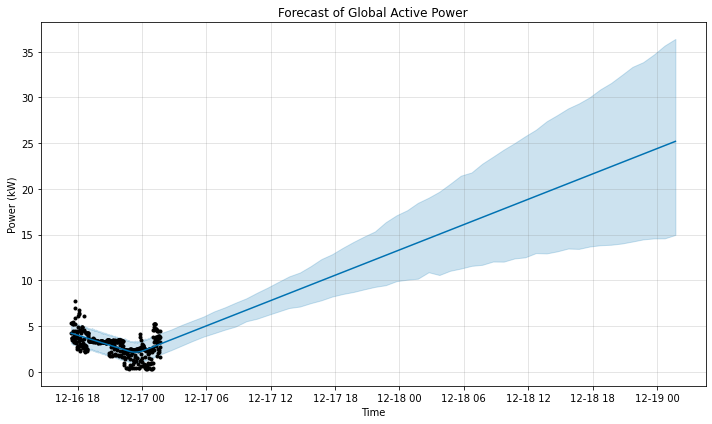

In [0]:
import matplotlib.pyplot as plt

fig = model.plot(forecast)
plt.title("Forecast of Global Active Power")
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.grid(True)
plt.tight_layout()
plt.show()
